In [1]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(1)

In [2]:
class MLPDataset(Dataset):
    def __init__(self, target_model, n_points):
        self.target_model = target_model
        self.n_points = n_points
        self.n_val_points = int(self.n_points * 0.25)
        with torch.no_grad():
            self.output = self.target_model(self.__input())
            self.val_output = self.target_model(self.__val_input())
            print('train ds mean: ', self.output.mean(), ' std: ', self.output.std())
            print('val ds mean: ', self.val_output.mean(), ' std: ', self.val_output.std())
        
    def __input(self):
        self.input = 1.0 * torch.randn(self.n_points, self.__input_shape()) + 3.0
        return self.input

    def __val_input(self):
        self.val_input = 1.0 * torch.randn(self.n_points, self.__input_shape()) + 3.0
        return self.val_input
        
    def __input_shape(self):
        first_parameter = next(self.target_model.parameters())
        input_shape = first_parameter.size()
        return input_shape[1]

    def __len__(self):
        return self.n_points

    def __getitem__(self, index):
        return self.input[index], self.output[index]

    def plot(self):
        x = self.input[:, 0].tolist()
        y = self.input[:, 1].tolist()
        z = self.output.squeeze().tolist()
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(x, y, z)
        plt.show()
        

In [3]:
class Target(nn.Module):
    def __init__(self, inp, out, hid, n_hidden, act):
        super().__init__()

        init_uniform_left = -3.0
        init_uniform_right = 3.0
        # activation
        activation = nn.Tanh();
        if act == 'relu':
            activation = nn.ReLU()

        # input layer
        input_layer = nn.Linear(inp, hid)
        self.layers = [input_layer, activation]

        # hidden layers
        for h in range(n_hidden):
            hidden_layer = nn.Linear(hid, hid)
            self.layers.append(hidden_layer)
            self.layers.append(activation)

        # output layer
        output_layer = nn.Linear(hid, out)
        self.layers.append(output_layer)

        # init
        for l in self.layers:
            if isinstance(l, nn.Linear):
                nn.init.uniform_(l.weight, init_uniform_left, init_uniform_right)

        # model list
        self.module_list = nn.ModuleList(self.layers)
        print(self)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

In [4]:
dataset = MLPDataset(Target(inp=4, out=4, hid=4, n_hidden=8, act='relu'), 7000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Target(
  (module_list): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=4, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4, out_features=4, bias=True)
    (11): ReLU()
    (12): Linear(in_features=4, out_features=4, bias=True)
    (13): ReLU()
    (14): Linear(in_features=4, out_features=4, bias=True)
    (15): ReLU()
    (16): Linear(in_features=4, out_features=4, bias=True)
    (17): ReLU()
    (18): Linear(in_features=4, out_features=4, bias=True)
  )
)
train ds mean:  tensor(-327.6971)  std:  tensor(616.5906)
val ds mean:  tensor(-329.5823)  std:  tensor(620.5104)


In [5]:
class MyModel(nn.Module):
    def __init__(self, inp, out, hid, n_hidden, act, use_dp, use_bn):
        super().__init__()
        # dropout
        dropout_prob = 0.25
        
        # activation
        activation = nn.ReLU()
        if act == 'tanh':
            activation = nn.Tanh()

        # layers
        self.layers = []

        # input layer
        input_layer = nn.Linear(inp, hid)
        self.layers.append(input_layer)
        if use_dp:
            dropout = nn.Dropout(dropout_prob)
            self.layers.append(dropout)
        self.layers.append(activation)
        if use_bn:
            bn = nn.BatchNorm1d(hid)
            self.layers.append(bn)

        # hidden layers
        for h in range(n_hidden):
            hidden = nn.Linear(hid, hid)
            self.layers.append(hidden)
            if use_dp:
                dropout = nn.Dropout(dropout_prob)
                self.layers.append(dropout)
            self.layers.append(activation)
            if use_bn:
                bn = nn.BatchNorm1d(hid)
                self.layers.append(bn)

        # output layer
        output_layer = nn.Linear(hid, out)
        self.layers.append(output_layer)

        # init
        for l in self.layers:
            if isinstance(l, nn.Linear):
                nn.init.kaiming_uniform_(l.weight, mode='fan_in')

        # model list
        self.module_list = nn.ModuleList(self.layers)
        print(self)
        
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

In [6]:
def train(model, dataloader, optim, loss_fn):
    loss = 0
    model.train()
    for i, (x_batch, y_batch) in enumerate(dataloader):
        optim.zero_grad() 
        pred = model(x_batch)
        loss_curr = loss_fn(pred, y_batch)
        loss_curr.backward()
        optimizer.step()
        loss += loss_curr.log10().item()
    loss /= len(dataloader)
    return loss

def validate(model, loss_fn):
    model.eval()
    with torch.no_grad():
        return loss_fn(model(dataset.val_input), dataset.val_output).log10().item()

In [7]:
num_epochs = 50
learning_rate = 0.1
model = MyModel(inp=4, out=4, hid=8, n_hidden=8, act='tanh', use_dp=False, use_bn=True)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

MyModel(
  (module_list): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): Tanh()
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Tanh()
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=8, out_features=8, bias=True)
    (10): Tanh()
    (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=8, out_features=8, bias=True)
    (13): Tanh()
    (14): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=8, out_features=8, bias=True)
    (16): Tanh()
    (17): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_ru

In [8]:
loss_hist = [0]*num_epochs
val_loss_hist = [0]*num_epochs

for epoch in range(num_epochs):
    if epoch % 10 == 0:
        optimizer.param_groups[0]['lr'] = 1e-1 * optimizer.param_groups[0]['lr']
    time_start = time.time()

    loss_hist[epoch] = train(model, dataloader, optimizer, loss_fn)
    val_loss_hist[epoch] = validate(model, loss_fn)
    
    time_end = time.time()
    time_delta = time_end - time_start

Text(0.5, 0, 'Epochs')

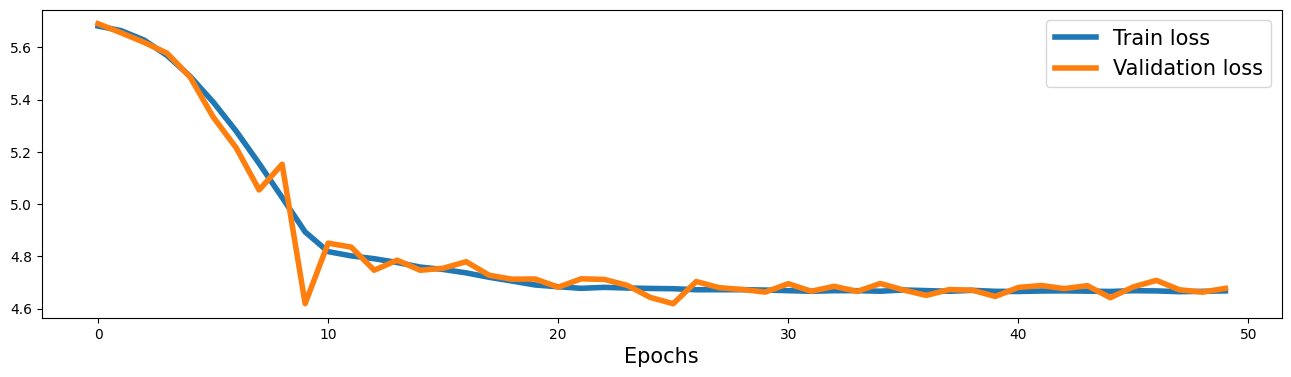

In [9]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot()
ax.plot(loss_hist, lw=4)
ax.plot(val_loss_hist, lw=4)
ax.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [10]:
# end here =================================================================================

In [11]:
class Hook():
    def __init__(self, name, module, backward=False):
        self.name = name
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
            
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
        
    def close(self):
        self.hook.remove()

In [12]:
from collections import namedtuple

fwd = {}
bwd = {}
InOut = namedtuple('InOut', ['input', 'output'])

loss_hist = [0]*num_epochs
val_loss_hist = [0]*num_epochs

for epoch in range(num_epochs):
    if epoch % 10 == 0:
        optimizer.param_groups[0]['lr'] = 1e-1 * optimizer.param_groups[0]['lr']
    for i, (x_batch, y_batch) in enumerate(dataloader):
        if epoch == 10 and i == 0:
            # 1. Register hooks on each layer
            hookF = [Hook(layer[0], layer[1]) for layer in list(model._modules.items())]
            hookB = [Hook(layer[0], layer[1],backward=True) for layer in list(model._modules.items())]
            
        # 2. Generate predictions
        pred = model(x_batch)
        
        # 3. Calculate loss
        loss = loss_fn(pred, y_batch)
        
        # 4. Compute gradients
        loss.backward()

        # 5. Forward/Backward Hooks Inputs & Outputs
        if epoch == 10 and i == 0:
            for hook in hookF:
                fwd[hook.name] = InOut(hook.input, hook.output)
            for hook in hookB:
                bwd[hook.name] = InOut(hook.input, hook.output)
    
        # 6. Update parameters using gradients
        optimizer.step()

        # 7. Reset the gradients to zero
        optimizer.zero_grad()

        with torch.no_grad():
            val_loss_hist[epoch] += loss_fn(model(dataset.val_input), dataset.val_output).log10().item()

        loss_hist[epoch] += loss.log10().item()
    loss_hist[epoch] /= len(dataloader)
    val_loss_hist[epoch] /= len(dataloader)

AttributeError: 'Hook' object has no attribute 'input'

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for k, v in fwd.items():
    if k == 'tanh_2' or k == 'tanh_5' or k == 'tanh_8' or k == 'tanh_11':
        print(k, ' mean: ', v.output.mean().item(), ' std: ', v.output.std().item(), ' saturation: ', (v.output.abs() > 0.97).float().mean().item()*100)
        hy, hx = torch.histogram(v.output, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {k}')
plt.legend(legends);
plt.title('tanh activation distribution')

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for k, v in bwd.items():
    if k == 'tanh_2' or k == 'tanh_5' or k == 'tanh_8' or k == 'tanh_11':
        print(k, ' mean: ', v.output[0].mean().item(), ' std: ', ' saturation: ', v.output[0].std().item(), (v.output[0].abs() > 0.97).float().mean().item()*100)
        hy, hx = torch.histogram(v.output[0], density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {k}')
plt.legend(legends);
plt.title('tanh activation distribution')

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot()
ax.plot(loss_hist, lw=4)
ax.plot(val_loss_hist, lw=4)
ax.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)